nx: [9, 9]
---------- 2D Space Group ----------
Using Hall Number: 477
Symmetry Symbol: P6mm
Number of symmetry operations: 12
Original mesh size: 81
Irreducible mesh size: 12
Reduced basis w: (1, 12)
Converted w: (1, 81)


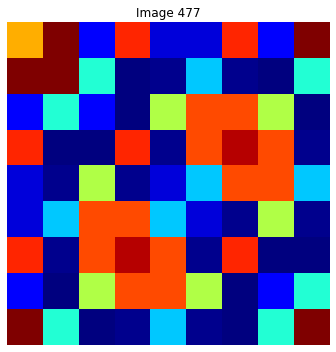

In [ ]:
import numpy as np
import json
import spglib
import scipy.io
import matplotlib.pyplot as plt

class SpaceGroup:
    def __init__(self, nx, symbol, hall_number=None):
        """
        Args:
            nx (tuple/list): Number of grid points in each dimension (e.g., [64, 64]).
            symbol (str): Space/Plane/Line group symbol (e.g., 'Ia-3d', 'p4m', 'P 4 m m').
            hall_number (int, optional): Explicit spglib Hall number. 
                                         If provided, it overrides the symbol lookup.
        """
        # # --- Internal Mappings (based on unique axis c for 2D) ---
        # PLANE_TO_SERIAL = {
        #     'p1': 1, 'p2': 4, 'pm': 18, 'pg': 21, 'cm': 30,
        #     'pmm2': 125, 'pma2': 137, 'pba2': 161, 'cmm2': 173,
        #     'p4': 349, 'p4mm': 376, 'p4bm': 377,
        #     'p3': 430, 'p3m1': 446, 'p31m': 447,
        #     'p6': 462, 'p6mm': 477,
        # }
        
        # # Seto symbols often use spaces or specific labels; we normalize them for the lookup
        # # This maps shorthand like 'p4m' or 'P 4 m m' to the same ID.
        # SHORTHAND_2D = {
        #     'p1': 'p1', 'p2': 'p2', 'pm': 'pm', 'p1m1': 'pm', 'pg': 'pg', 'p1c1': 'pg', 'cm': 'cm',
        #     'pmm': 'pmm2', 'pmg': 'pma2', 'pgg': 'pba2', 'cmm': 'cmm2',
        #     'p4m': 'p4mm', 'p4g': 'p4bm', 'p6m': 'p6mm'
        # }

        # LINE_TO_SERIAL = {
        #     'p1': 1, 
        #     'pm': 20  # ITA 6, Setting P m 1 1 (Mirror perp to x)
        # }

        self.nx = np.array(nx)
        self.dim = len(self.nx)

        if self.dim != 3:
            raise ValueError("Currently, Only 3D space groups are supported.")

        print(f"---------- {self.dim}D Space Group ----------")

        # --- Resolve Hall Number and Symbol ---
        # Clean symbol for dictionary lookup
        sym_clean = symbol.lower().replace(" ", "")

        # if self.dim == 3:
        #     pass
        # elif self.dim == 2:
        #     sym_clean = SHORTHAND_2D.get(sym_clean, sym_clean)
        #     if sym_clean.lower() not in PLANE_TO_SERIAL:
        #         raise ValueError(f"Unknown 2D symbol '{symbol}'. Use ITA or shorthand (e.g., 'p4m').")
        # elif self.dim == 1:
        #     if sym_clean not in LINE_TO_SERIAL:
        #         raise ValueError(f"Unknown 1D symbol '{symbol}'. Use 'p1' or 'pm'.")
        # else:
        #     raise ValueError("Dimension must be 1, 2, or 3.")

        if hall_number is None:
            # Find the ITA Hall number via spglib
            h_nums = [h for h in range(1, 531)
                        if spglib.get_spacegroup_type(h).international_short.strip().lower() == symbol.strip().lower()]
            if not h_nums:
                raise ValueError(f"Symbol '{symbol}' not found in spglib.")
            if len(h_nums) > 1:
                print(f"Warning: Multiple settings for {symbol}. Using Hall {h_nums[0]}.")
            self.hall_number = h_nums[0]
        else:
            # Check the Hall number
            inter_short = spglib.get_spacegroup_type(hall_number).international_short
            if inter_short.strip().lower() != symbol.strip().lower():
                raise ValueError(f"Symbol mismatch: {self.spacegroup_symbol} != {symbol}. Please check the provided symbol and Hall number.")
            self.hall_number = hall_number

        self.spacegroup_symbol = spglib.get_spacegroup_type(self.hall_number).international_short
        print(f"Using Hall Number: {self.hall_number}")
        print(f"Symmetry Symbol: {self.spacegroup_symbol}")

        # Use spglib to get information from the Hall number
        spg_type_info = spglib.get_spacegroup_type(self.hall_number)
        self.spacegroup_number = spg_type_info.number

        # Map the international number to the crystal system and lattice parameters
        self.crystal_system, self.lattice_parameters = self.get_crystal_system(self.spacegroup_number)

        # Print the international space group number and symbol
        print(f"International space group number: {self.spacegroup_number}")
        # print(f"International space group symbol: {self.spacegroup_symbol}")
        print(f"Crystal system: {self.crystal_system}")

        # --- Symmetry and Mesh Generation ---
        self.symmetry_operations = self.get_symmetry_ops(self.hall_number, dim=self.dim)
        self.irreducible_mesh, self.indices = self.find_irreducible_mesh(self.nx, self.symmetry_operations)

        print(f"Number of symmetry operations: {len(self.symmetry_operations)}")
        print(f"Original mesh size: {np.prod(self.nx)}")
        print(f"Irreducible mesh size: {len(self.irreducible_mesh)}")

        # --- Flattened mappings for performance ---
        # multi_indices: (dim, num_irreducible_points)
        multi_indices = np.array(self.irreducible_mesh).T
        self.reduced_basis_flat_indices_ = np.ravel_multi_index(multi_indices, self.nx)
        self.full_to_reduced_map_flat_ = self.indices.flatten()

    def get_symmetry_ops(self, hall_number, dim=3):
        """Slices 3D spglib operations to the target dimension."""
        symmetries = spglib.get_symmetry_from_database(hall_number)
        rotations = symmetries['rotations']
        translations = symmetries['translations']
        
        unique_ops = []
        seen = set()
        for R, t in zip(rotations, translations):
            # Take the sub-matrix/vector for 1D (x) or 2D (x, y)
            R_sub = R[:dim, :dim]
            t_sub = t[:dim]
            
            # Key uses byte representation to handle numpy arrays in a set
            key = (R_sub.tobytes(), np.round(t_sub, 6).tobytes())
            if key not in seen:
                unique_ops.append((R_sub, t_sub))
                seen.add(key)
        return unique_ops

    def find_irreducible_mesh(self, grid_size, symmetry_operations):
        """Dimension-agnostic grid reduction."""
        indices = np.full(grid_size, -1, dtype=np.int32)
        irreducible_points = []
        grid_size_arr = np.array(grid_size)
        count = 0

        # Iterates over 1D, 2D, or 3D indices automatically
        for point_int in np.ndindex(*grid_size):
            if indices[tuple(point_int)] == -1:
                irreducible_points.append(point_int)
                p_frac = np.array(point_int) / grid_size_arr
                
                for R, t in symmetry_operations:
                    # p' = R*p + t (periodic)
                    new_p_frac = np.dot(R, p_frac) + t
                    new_p_int = np.mod(np.round(new_p_frac * grid_size_arr).astype(int), grid_size_arr)
                    indices[tuple(new_p_int)] = count
                count += 1
        return irreducible_points, indices

    def to_reduced_basis(self, fields):
        fields_flat = np.reshape(fields, (fields.shape[0], -1))
        return fields_flat[:, self.reduced_basis_flat_indices_].copy()

    def from_reduced_basis(self, reduced_fields):
        return reduced_fields[:, self.full_to_reduced_map_flat_].copy()
    
    def get_crystal_system(self, spg_number):
        """
        Maps an international space group number to its crystal system name and lattice parameters
        """
        if 1 <= spg_number <= 2:
            return "Triclinic", ["a", "b", "c", "alpha", "beta", "gamma"]
        elif 3 <= spg_number <= 15:
            return "Monoclinic", ["a", "b", "c", "beta"]
        elif 16 <= spg_number <= 74:
            return "Orthorhombic", ["a", "b", "c"]
        elif 75 <= spg_number <= 142:
            return "Tetragonal", ["a", "c"]
        elif 143 <= spg_number <= 167:
            return "Trigonal", ["a", "c"]
        elif 168 <= spg_number <= 194:
            return "Hexagonal", ["a", "c"]
        elif 195 <= spg_number <= 230:
            return "Cubic", ["a"]
        else:
            raise ValueError("Invalid space group number.")

# ==============================================================================
# Main execution block
# ==============================================================================
if __name__ == '__main__':

    # for hall_number in range(477,490):
    #     spg_type_info = spglib.get_spacegroup_type(hall_number)
    #     print(hall_number, spg_type_info.international_short)

    grid = 9
    nx = [grid, grid]
    w = np.random.uniform(0.0, 1.0, size=[1, np.prod(nx)])

    print(f"nx: {nx}")

    hall_number = 477
    spg_type_info = spglib.get_spacegroup_type(hall_number)

    sg = SpaceGroup(nx, spg_type_info.international_short, hall_number=hall_number)
    # sg = SpaceGroup(nx, "P6mm", hall_number=477)
    # sg = SpaceGroup(nx, "P6_3/mmc", hall_number=488)

    w_reduced_basis = sg.to_reduced_basis(w)
    print("Reduced basis w:", w_reduced_basis.shape)
    w_converted = sg.from_reduced_basis(w_reduced_basis)
    print("Converted w:", w_converted.shape)
    w_converted = w_converted.reshape(np.array(nx))

    w_converted = np.roll(w_converted, 0, axis=(0,1))
    fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

    # Display the first image on the left axes (ax1)
    ax1.imshow(w_converted, cmap='jet')
    ax1.set_title(f'Image {hall_number}')
    ax1.axis('off') # Hide axes ticks for cleaner image display

    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()

    # Display the figure
    plt.show()

In [2]:
    # grid = 9
    # nx = [2, grid, grid]
    # w = np.random.uniform(0.0, 1.0, size=[1, np.prod(nx)])

    # print(f"nx: {nx}")

    # for hall_number in range(462, 489):
    #     try:
    #         spg_type_info = spglib.get_spacegroup_type(hall_number)

    #         sg = SpaceGroup(nx, spg_type_info.international_short, hall_number=hall_number)
    #         # sg = SpaceGroup(nx, "P6mm", hall_number=477)
    #         # sg = SpaceGroup(nx, "P6_3/mmc", hall_number=488)

    #         w_reduced_basis = sg.to_reduced_basis(w)
    #         print("Reduced basis w:", w_reduced_basis.shape)
    #         w_converted = sg.from_reduced_basis(w_reduced_basis)
    #         print("Converted w:", w_converted.shape)
    #         w_converted = w_converted.reshape(np.array(nx))
    #         w_converted = w_converted[0,:,:].reshape(np.array(nx)[1:])

    #         w_converted = np.roll(w_converted, 0, axis=(0,1))
    #         fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

    #         # Display the first image on the left axes (ax1)
    #         ax1.imshow(w_converted, cmap='jet')
    #         ax1.set_title(f'Image {hall_number}')
    #         ax1.axis('off') # Hide axes ticks for cleaner image display

    #         # Adjust layout to prevent titles/labels from overlapping
    #         plt.tight_layout()

    #         # Display the figure
    #         plt.show()  
    #     except Exception as e:
    #         print(f"Error Occur: {e}")
